In [3]:
import torch
import torch.nn.functional as F
import numpy as np
import math
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow

In [4]:
!git clone https://github.com/pranjaldatta/SSIM-PyTorch.git

Cloning into 'SSIM-PyTorch'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 16 (delta 3), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (16/16), 1.30 MiB | 3.47 MiB/s, done.


In [5]:
def gaussian(window_size, sigma):
    """
    Generates a list of Tensor values drawn from a gaussian distribution with standard
    diviation = sigma and sum of all elements = 1.

    Length of list = window_size
    """
    gauss =  torch.Tensor([math.exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

In [6]:
gauss_dis = gaussian(11, 1.5)
print("Distribution: ", gauss_dis)
print("Sum of Gauss Distribution:", torch.sum(gauss_dis))

Distribution:  tensor([0.0010, 0.0076, 0.0360, 0.1094, 0.2130, 0.2660, 0.2130, 0.1094, 0.0360,
        0.0076, 0.0010])
Sum of Gauss Distribution: tensor(1.)


In [7]:
def create_window(window_size, channel=1):

    # Generate an 1D tensor containing values sampled from a gaussian distribution
    _1d_window = gaussian(window_size=window_size, sigma=1.5).unsqueeze(1)

    # Converting to 2D
    _2d_window = _1d_window.mm(_1d_window.t()).float().unsqueeze(0).unsqueeze(0)

    window = torch.Tensor(_2d_window.expand(channel, 1, window_size, window_size).contiguous())

    return window



In [8]:
window = create_window(11, 3)
print("Shape of gaussian window:", window.shape)

Shape of gaussian window: torch.Size([3, 1, 11, 11])


In [9]:
def ssim(img1, img2, val_range, window_size=11, window=None, size_average=True, full=False):

    L = val_range # L is the dynamic range of the pixel values (255 for 8-bit grayscale images),

    pad = window_size // 2

    try:
        _, channels, height, width = img1.size()
    except:
        channels, height, width = img1.size()

    # if window is not provided, init one
    if window is None:
        real_size = min(window_size, height, width) # window should be atleast 11x11
        window = create_window(real_size, channel=channels).to(img1.device)

    # calculating the mu parameter (locally) for both images using a gaussian filter
    # calculates the luminosity params
    mu1 = F.conv2d(img1, window, padding=pad, groups=channels)
    mu2 = F.conv2d(img2, window, padding=pad, groups=channels)

    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2
    mu12 = mu1 * mu2

    # now we calculate the sigma square parameter
    # Sigma deals with the contrast component
    sigma1_sq = F.conv2d(img1 * img1, window, padding=pad, groups=channels) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=pad, groups=channels) - mu2_sq
    sigma12 =  F.conv2d(img1 * img2, window, padding=pad, groups=channels) - mu12

    # Some constants for stability
    C1 = (0.01 ) ** 2  # NOTE: Removed L from here (ref PT implementation)
    C2 = (0.03 ) ** 2

    contrast_metric = (2.0 * sigma12 + C2) / (sigma1_sq + sigma2_sq + C2)
    contrast_metric = torch.mean(contrast_metric)

    numerator1 = 2 * mu12 + C1
    numerator2 = 2 * sigma12 + C2
    denominator1 = mu1_sq + mu2_sq + C1
    denominator2 = sigma1_sq + sigma2_sq + C2

    ssim_score = (numerator1 * numerator2) / (denominator1 * denominator2)

    if size_average:
        ret = ssim_score.mean()
    else:
        ret = ssim_score.mean(1).mean(1).mean(1)

    if full:
        return ret, contrast_metric

    return ret


In [10]:
# helper function to load images
load_images = lambda x: np.asarray(Image.open(x))

# Helper functions to convert to Tensors
tensorify = lambda x: torch.Tensor(x.transpose((2, 0, 1))).unsqueeze(0).float().div(255.0)

# display imgs
def display_imgs(x, transpose=True, resize=True):
  if transpose:
    cv2_imshow(cv2.cvtColor(x, cv2.COLOR_BGR2RGB))
  else:
    cv2_imshow(x)

(512, 512)
Inpute Image


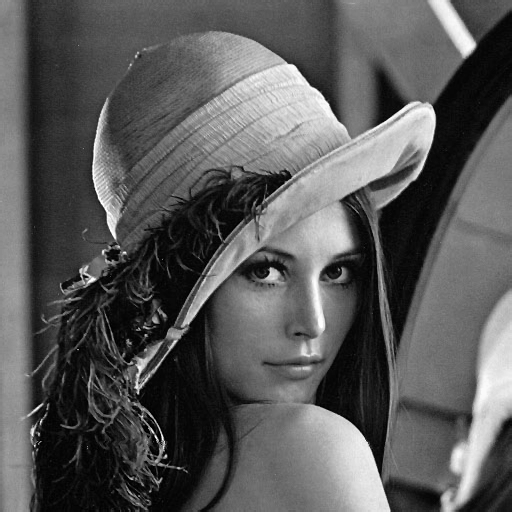

Denoised Image


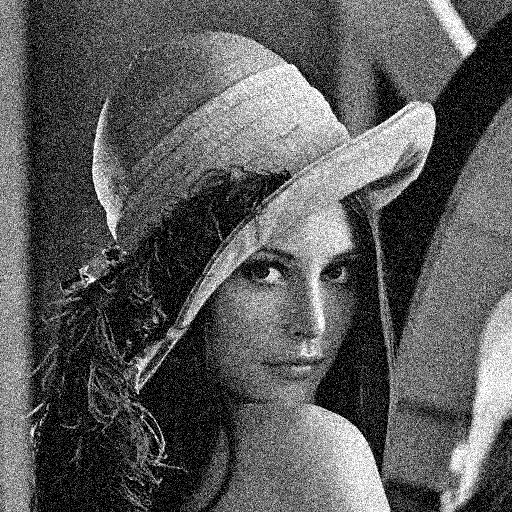

In [38]:
# The true reference Image
input = load_images("/content/input.png")
s=np.shape(input)
print(s)
# The False image
#noised = load_images("/content/noised_BW.png")

#denoised = load_images("/content/output_BW_SB.png")

# The noised true image
noise = np.random.normal(0, 36, (s[0], s[1])).astype(np.float32)
noisy_img = input + noise

print("Input Image")
display_imgs(input)

#print("Noised Image")
#display_imgs(noised)

#print("Denoised Image")
#display_imgs(denoised)

print("Denoised Image")
display_imgs(noisy_img)


In [62]:
# Check SSIM score of True image vs False Image
input = cv2.imread("/content/input.png", cv2.IMREAD_GRAYSCALE)
input = np.atleast_3d(input)

noised = cv2.imread("/content/noised_BW.png",cv2.IMREAD_GRAYSCALE)
noised = np.atleast_3d(noised)


denoised = cv2.imread("/content/output_BW_SB.png",cv2.IMREAD_GRAYSCALE)
denoised = np.atleast_3d(denoised)

Input = tensorify(input)
Noised = tensorify(noised)
Denoised = tensorify(denoised)
input_vs_noised = ssim(Input, Noised, val_range=255)
input_vs_denoised = ssim(Input, Denoised, val_range=255)
noised_vs_denoised = ssim(Noised, Denoised, val_range=255)
print("Input vs Noised Image SSIM Score:", input_vs_noised)
print("Input vs Denoised Image SSIM Score:", input_vs_denoised)
print("Noised vs Denoised Image SSIM Score:", noised_vs_denoised)

Input vs Noised Image SSIM Score: tensor(0.2192)
Input vs Denoised Image SSIM Score: tensor(0.6533)
Noised vs Denoised Image SSIM Score: tensor(0.3855)


In [63]:
# Check SSIM score of True image vs False Image
denoised = cv2.imread("/content/output_BW_ADMM.png",cv2.IMREAD_GRAYSCALE)
denoised = np.atleast_3d(denoised)
Denoised = tensorify(denoised)
input_vs_noised = ssim(Input, Noised, val_range=255)
input_vs_denoised = ssim(Input, Denoised, val_range=255)
noised_vs_denoised = ssim(Noised, Denoised, val_range=255)
print("Input vs Noised Image SSIM Score:", input_vs_noised)
print("Input vs Denoised Image SSIM Score:", input_vs_denoised)
print("Noised vs Denoised Image SSIM Score:", noised_vs_denoised)

Input vs Noised Image SSIM Score: tensor(0.2192)
Input vs Denoised Image SSIM Score: tensor(0.6316)
Noised vs Denoised Image SSIM Score: tensor(0.4086)


In [64]:
# Check SSIM score of True image vs False Image
denoised = cv2.imread("/content/output_BW_PD_SNR.png",cv2.IMREAD_GRAYSCALE)
denoised = np.atleast_3d(denoised)
Denoised = tensorify(denoised)
input_vs_noised = ssim(Input, Noised, val_range=255)
input_vs_denoised = ssim(Input, Denoised, val_range=255)
noised_vs_denoised = ssim(Noised, Denoised, val_range=255)
print("Input vs Noised Image SSIM Score:", input_vs_noised)
print("Input vs Denoised Image SSIM Score:", input_vs_denoised)
print("Noised vs Denoised Image SSIM Score:", noised_vs_denoised)

Input vs Noised Image SSIM Score: tensor(0.2192)
Input vs Denoised Image SSIM Score: tensor(0.4513)
Noised vs Denoised Image SSIM Score: tensor(0.6905)


In [66]:
# Check SSIM score of True image vs False Image
denoised = cv2.imread("/content/output_BW_FGP.png",cv2.IMREAD_GRAYSCALE)
denoised = np.atleast_3d(denoised)
Denoised = tensorify(denoised)
input_vs_noised = ssim(Input, Noised, val_range=255)
input_vs_denoised = ssim(Input, Denoised, val_range=255)
noised_vs_denoised = ssim(Noised, Denoised, val_range=255)
print("Input vs Noised Image SSIM Score:", input_vs_noised)
print("Input vs Denoised Image SSIM Score:", input_vs_denoised)
print("Noised vs Denoised Image SSIM Score:", noised_vs_denoised)

Input vs Noised Image SSIM Score: tensor(0.2192)
Input vs Denoised Image SSIM Score: tensor(0.6332)
Noised vs Denoised Image SSIM Score: tensor(0.4087)


In [67]:
# Check SSIM score of True image vs False Image
denoised = cv2.imread("/content/output_BW_ADMM_ATV.png",cv2.IMREAD_GRAYSCALE)
denoised = np.atleast_3d(denoised)
Denoised = tensorify(denoised)
input_vs_noised = ssim(Input, Noised, val_range=255)
input_vs_denoised = ssim(Input, Denoised, val_range=255)
noised_vs_denoised = ssim(Noised, Denoised, val_range=255)
print("Input vs Noised Image SSIM Score:", input_vs_noised)
print("Input vs Denoised Image SSIM Score:", input_vs_denoised)
print("Noised vs Denoised Image SSIM Score:", noised_vs_denoised)

Input vs Noised Image SSIM Score: tensor(0.2192)
Input vs Denoised Image SSIM Score: tensor(0.6889)
Noised vs Denoised Image SSIM Score: tensor(0.3102)


In [68]:
# Check SSIM score of True image vs False Image
denoised = cv2.imread("/content/output_BW_SB_ATV.png",cv2.IMREAD_GRAYSCALE)
denoised = np.atleast_3d(denoised)
Denoised = tensorify(denoised)
input_vs_noised = ssim(Input, Noised, val_range=255)
input_vs_denoised = ssim(Input, Denoised, val_range=255)
noised_vs_denoised = ssim(Noised, Denoised, val_range=255)
print("Input vs Noised Image SSIM Score:", input_vs_noised)
print("Input vs Denoised Image SSIM Score:", input_vs_denoised)
print("Noised vs Denoised Image SSIM Score:", noised_vs_denoised)

Input vs Noised Image SSIM Score: tensor(0.2192)
Input vs Denoised Image SSIM Score: tensor(0.6257)
Noised vs Denoised Image SSIM Score: tensor(0.4301)


In [70]:
# Check SSIM score of True image vs False Image
denoised = cv2.imread("/content/output_BW_FGP_ATV.png",cv2.IMREAD_GRAYSCALE)
denoised = np.atleast_3d(denoised)
Denoised = tensorify(denoised)
input_vs_noised = ssim(Input, Noised, val_range=255)
input_vs_denoised = ssim(Input, Denoised, val_range=255)
noised_vs_denoised = ssim(Noised, Denoised, val_range=255)
print("Input vs Noised Image SSIM Score:", input_vs_noised)
print("Input vs Denoised Image SSIM Score:", input_vs_denoised)
print("Noised vs Denoised Image SSIM Score:", noised_vs_denoised)

Input vs Noised Image SSIM Score: tensor(0.2192)
Input vs Denoised Image SSIM Score: tensor(0.6907)
Noised vs Denoised Image SSIM Score: tensor(0.3102)
